#### Importing the required libraries and the required data from yahoo finance

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller

print("Fetching Apple stock data...")
df = yf.download('AAPL', start='2023-01-01', end='2024-12-31', progress=False)

print(f"Downloaded {len(df)} days of data")
print(df.head())

Fetching Apple stock data...
Downloaded 501 days of data
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.211212  128.954561  122.324586  128.343780  112117500
2023-01-04  124.482040  126.747861  123.221065  125.004162   89113600
2023-01-05  123.161934  125.871063  122.905803  125.240575   80962700
2023-01-06  127.693596  128.353637  123.033897  124.137254   87754700
2023-01-09  128.215729  131.427289  127.959598  128.530980   70790800


/var/folders/zp/_z5ytlrj39x9_lyt_g51rrfm0000gn/T/ipykernel_29198/3991834588.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2023-01-01', end='2024-12-31', progress=False)


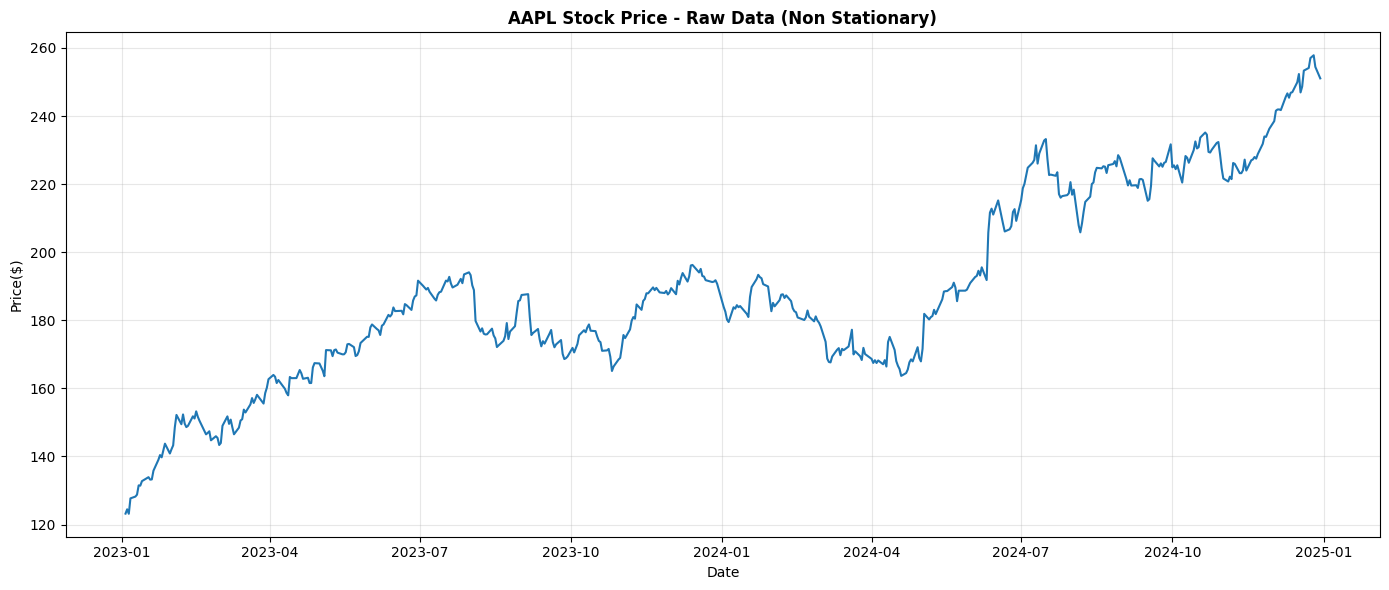

Notice the clear upward trend? That's non-stationarity!


In [9]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'])
plt.title('AAPL Stock Price - Raw Data (Non Stationary)',fontweight = 'bold')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice the clear upward trend? That's non-stationarity!")

#### Performing the ADF test to check for stationarity

In [10]:
def perform_adf_test(series, name='Series'):
    result = adfuller(series.dropna())

    print(f"\n{'='*60}")
    print(f"ADF Test Results for: {name}")
    print(f"{'='*60}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"P-value: {result[1]:.6f}")
    print(f"Number of lags used: {result[2]}")
    print(f"Number of observations: {result[3]}")
    print(f"\nCritical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")

    print(f"\n{'='*60}")
    if result[1] < 0.05:
        print(f"✅ PASS: p-value < 0.05 → Data is STATIONARY")
    else:
        print(f"❌ FAIL: p-value > 0.05 → Data is NON-STATIONARY")
        print(f"   ⚠️  You cannot train an LSTM on this data!")
    print(f"{'='*60}\n")

    return result[1]  # Return p-value

# Test raw prices
p_value_raw = perform_adf_test(df['Close'], 'Raw Close Prices')


ADF Test Results for: Raw Close Prices
ADF Statistic: -1.126504
P-value: 0.704388
Number of lags used: 1
Number of observations: 499

Critical Values:
  1%: -3.444
  5%: -2.867
  10%: -2.570

❌ FAIL: p-value > 0.05 → Data is NON-STATIONARY
   ⚠️  You cannot train an LSTM on this data!



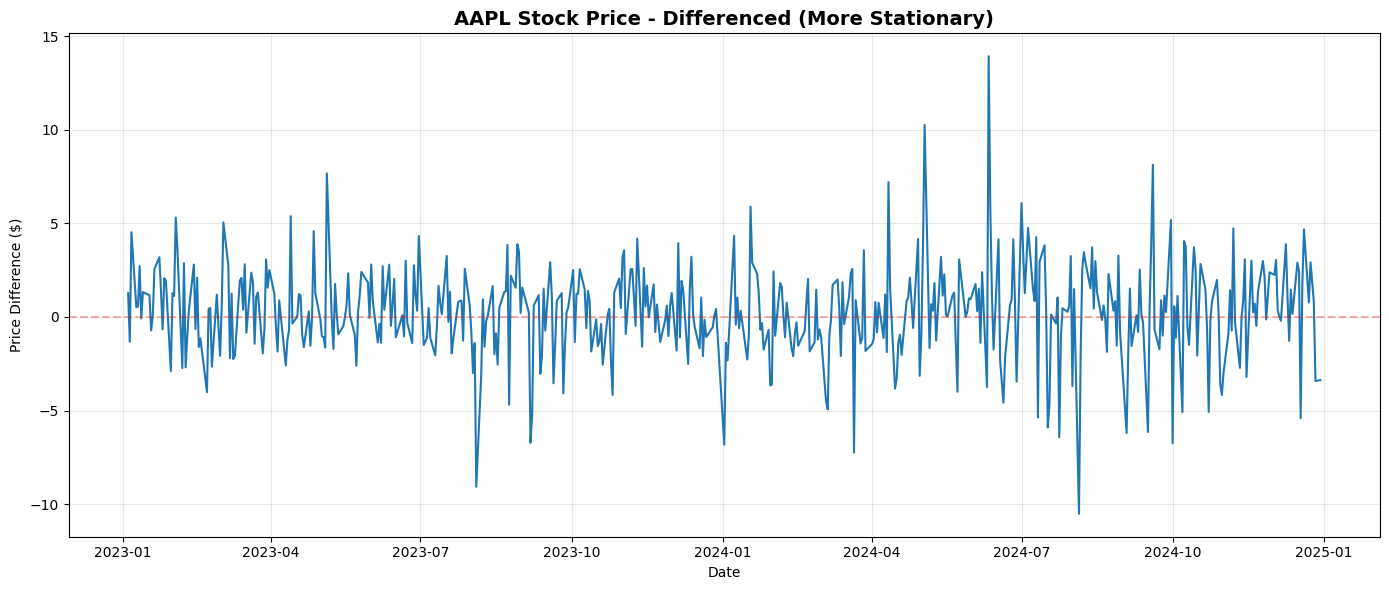

Notice: No clear trend, oscillates around 0!

ADF Test Results for: Differenced Prices
ADF Statistic: -20.863901
P-value: 0.000000
Number of lags used: 0
Number of observations: 499

Critical Values:
  1%: -3.444
  5%: -2.867
  10%: -2.570

✅ PASS: p-value < 0.05 → Data is STATIONARY



In [11]:
df['Price_Diff'] = df['Close'].diff()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Price_Diff'])
plt.title('AAPL Stock Price - Differenced (More Stationary)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice: No clear trend, oscillates around 0!")

differenced_series = df['Price_Diff'].dropna()
if differenced_series.empty:
    print("Error: Differenced series is empty after dropping NaNs. Cannot perform ADF test.")
    p_value_diff = None
else:
    p_value_diff = perform_adf_test(differenced_series, 'Differenced Prices')

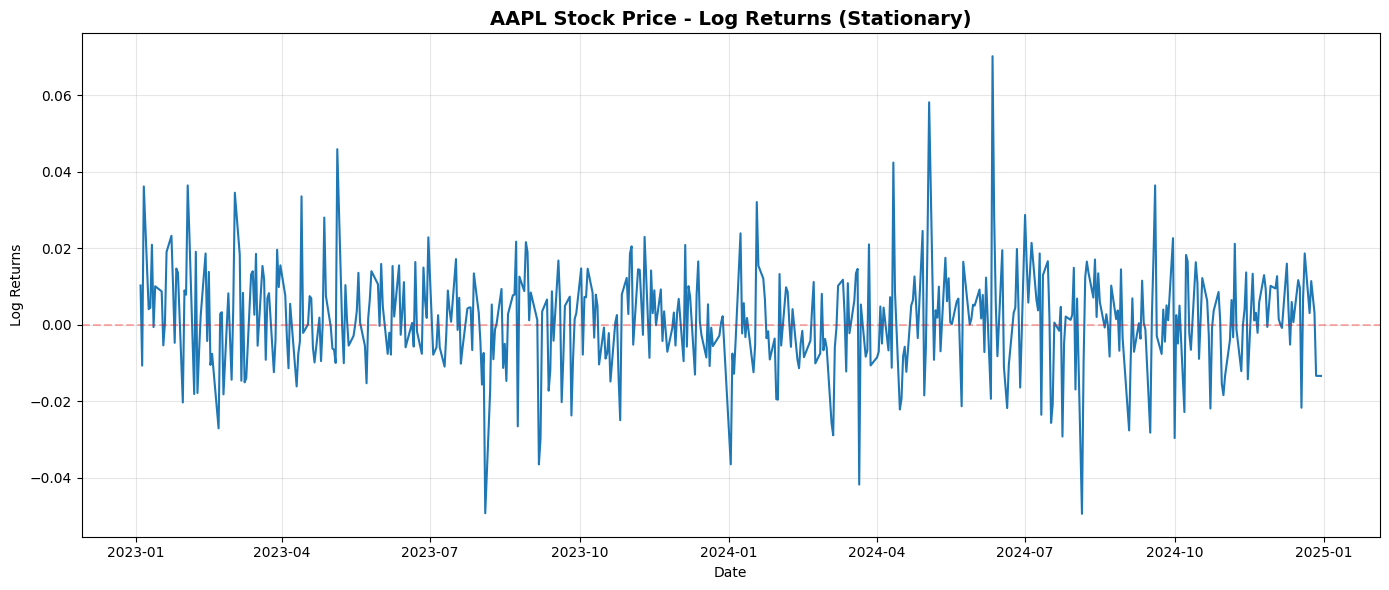

Notice: No clear trend, oscillates around 0!

ADF Test Results for: Log Returns
ADF Statistic: -20.935492
P-value: 0.000000
Number of lags used: 0
Number of observations: 499

Critical Values:
  1%: -3.444
  5%: -2.867
  10%: -2.570

✅ PASS: p-value < 0.05 → Data is STATIONARY



In [12]:
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Log_Returns'])
plt.title('AAPL Stock Price - Log Returns (Stationary)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice: No clear trend, oscillates around 0!")

log_series = df['Log_Returns'].dropna()

if log_series.empty:
    print("Error: Log series is empty after dropping NaNs. Cannot perform ADF test.")
    p_value_log = None
else:
    p_value_log = perform_adf_test(log_series, 'Log Returns')

In [13]:
results_df = pd.DataFrame({
    'Method': ['Raw Prices', 'Differencing', 'Log Returns'],
    'P-Value': [p_value_raw, p_value_diff, p_value_log],
    'Stationary': [p_value_raw < 0.05, p_value_diff < 0.05, p_value_log < 0.05]
})

results_df['Status'] = results_df['Stationary'].apply(lambda x: '✅ PASS' if x else '❌ FAIL')

print("\n" + "="*60)
print("SUMMARY: Stationarity Test Results")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)


SUMMARY: Stationarity Test Results
      Method  P-Value  Stationary Status
  Raw Prices 0.704388       False ❌ FAIL
Differencing 0.000000        True ✅ PASS
 Log Returns 0.000000        True ✅ PASS
